# **Proyecto: Turismo Emisivo Argentino (2016–2025)**

**Curso:** Data Science II  
**Entrega:** Primera entrega — EDA + Insights  
**Autor:** Santiago Quagliotti  
**Fecha:** 16/02/2026


## **Abstract**
El turismo emisivo (viajes de residentes argentinos al exterior) es relevante para agencias de viaje y analistas económicos, ya que refleja decisiones de consumo, estacionalidad y sensibilidad a variables macroeconómicas.

Este proyecto analiza la evolución temporal del turismo emisivo, los principales destinos y medios de transporte, y explora cómo se relaciona con variables externas como el tipo de cambio y el índice de salarios.

**Audiencia:** agencias de viaje, áreas comerciales, y analistas interesados en planificación y demanda.


## **Preguntas e hipótesis**

1. ¿Cómo evoluciona el turismo emisivo a lo largo del tiempo? ¿Existe estacionalidad marcada?

2. ¿Cuáles son los destinos más elegidos por los argentinos y cómo se distribuyen por medio de transporte?

3. ¿Cómo se relaciona el turismo emisivo con el tipo de cambio?  
   **Hipótesis:** un aumento en el tipo de cambio se asocia con una disminución en la cantidad de viajes al exterior.

4. ¿Existe relación entre el poder adquisitivo (índice de salarios) y la cantidad de viajes?  
   **Hipótesis:** un aumento en el índice de salarios (variación positiva mensual) se asocia con un incremento en los viajes al exterior.

5. ¿Los meses con mayor cantidad de feriados presentan mayores niveles de viajes?  
   **Hipótesis:** los feriados actúan como impulsores temporales de la demanda turística.

6. ¿Qué destinos son más sensibles o resilientes frente a variaciones en el tipo de cambio?


## **Librerías y configuración**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


## **1) Cargar dataset principal (CSV)**

Carga del dataset desde GitHub

El dataset se carga directamente desde una URL pública del repositorio para garantizar reproducibilidad y evitar la carga manual de archivos.

In [37]:
url = "https://raw.githubusercontent.com/santiagoq21/ds2-primera-entrega-turismo-emisivo/refs/heads/main/turistas-residentes-serie.csv"

df = pd.read_csv(url, encoding="utf-8-sig")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Convertir fecha
df["indice_tiempo"] = pd.to_datetime(df["indice_tiempo"], errors="coerce")

print("✅ Dataset cargado:", df.shape)
df.head()


✅ Dataset cargado: (3186, 4)


,indice_tiempo,medio_de_transporte,pais_destino,viajes_de_turistas_residentes
0,2016-01-01,Aérea,Bolivia,4196
1,2016-01-01,Aérea,Brasil,104681
2,2016-01-01,Aérea,Chile,28185
3,2016-01-01,Aérea,Paraguay,3093
4,2016-01-01,Aérea,Uruguay,15601


## **2) Metadata mínima del dataset**

In [39]:
print("Filas, Columnas:", df.shape)
print("\nTipos de datos:")
display(df.dtypes)

print("\nRango temporal:")
print("Min:", df["indice_tiempo"].min())
print("Max:", df["indice_tiempo"].max())

print("\nValores nulos por columna:")
display(df.isna().sum())


Filas, Columnas: (3186, 4)

Tipos de datos:


,0
indice_tiempo,datetime64[ns]
medio_de_transporte,object
pais_destino,object
viajes_de_turistas_residentes,int64



Rango temporal:
Min: 2016-01-01 00:00:00
Max: 2025-10-01 00:00:00

Valores nulos por columna:


,0
indice_tiempo,0
medio_de_transporte,0
pais_destino,0
viajes_de_turistas_residentes,0


### **2.1) Revisión rápida de categorías**

In [40]:
print("Medios de transporte:", df["medio_de_transporte"].unique())
print("Cantidad destinos:", df["pais_destino"].nunique())
print("Ejemplo destinos:", df["pais_destino"].unique()[:10])


Medios de transporte: ['Aérea' 'Fluvial/Marítima' 'Terrestre']
Cantidad destinos: 9
Ejemplo destinos: ['Bolivia' 'Brasil' 'Chile' 'Paraguay' 'Uruguay' 'EE.UU. y Canadá'
 'Resto de América' 'Europa' 'Resto del mundo']


## **3) API Tipo de Cambio (ArgentinaDatos)**

In [41]:
casa = "blue"

url = f"https://api.argentinadatos.com/v1/cotizaciones/dolares/{casa}"
r = requests.get(url, timeout=30)
r.raise_for_status()

dolar_hist = pd.DataFrame(r.json())
dolar_hist["fecha"] = pd.to_datetime(dolar_hist["fecha"], errors="coerce")
dolar_hist = dolar_hist.dropna(subset=["fecha"])

# Filtrar al rango del dataset principal
fecha_min = df["indice_tiempo"].min()
fecha_max = df["indice_tiempo"].max()

dolar_rango = dolar_hist[
    (dolar_hist["fecha"] >= fecha_min) &
    (dolar_hist["fecha"] <= fecha_max)
].copy()

# Convertir a frecuencia mensual (último valor del mes)
dolar_rango["indice_tiempo"] = dolar_rango["fecha"].dt.to_period("M").dt.to_timestamp()

df_dolar_mensual = (
    dolar_rango.sort_values("fecha")
    .groupby("indice_tiempo", as_index=False)
    .tail(1)
    .loc[:, ["indice_tiempo", "compra", "venta"]]
    .sort_values("indice_tiempo")
    .reset_index(drop=True)
)

df_dolar_mensual.head()


,indice_tiempo,compra,venta
0,2016-01-01,14,14
1,2016-02-01,15,16
2,2016-03-01,15,15
3,2016-04-01,14,15
4,2016-05-01,14,15


## **4) API Feriados (ArgentinaDatos)**

In [42]:
anio_min_api = 2021
anio_max_api = 2025

todos = []

for anio in range(anio_min_api, anio_max_api + 1):
    url = f"https://api.argentinadatos.com/v1/feriados/{anio}"
    resp = requests.get(url, timeout=30)
    if resp.status_code == 200:
        tmp = pd.DataFrame(resp.json())
        tmp["año"] = anio
        todos.append(tmp)
    else:
        print(f"Error {anio}: {resp.status_code}")

feriados = pd.concat(todos, ignore_index=True)
feriados["fecha"] = pd.to_datetime(feriados["fecha"], errors="coerce")
feriados = feriados.dropna(subset=["fecha"])

# Pasar a frecuencia mensual
feriados["indice_tiempo"] = feriados["fecha"].dt.to_period("M").dt.to_timestamp()

feriados_mensual = (
    feriados.groupby("indice_tiempo")
    .size()
    .reset_index(name="cantidad_feriados")
)

feriados_mensual.head()


,indice_tiempo,cantidad_feriados
0,2021-01-01,1
1,2021-02-01,2
2,2021-03-01,1
3,2021-04-01,1
4,2021-05-01,3


## **5) API Índice de Salarios (datos.gob.ar) - extracción robusta**

In [43]:
import requests
import pandas as pd

# Endpoint del Índice de Salarios (nivel general, mensual)
url_salarios = "https://apis.datos.gob.ar/series/api/series/?ids=148.3_INIVELNAL_DICI_M_26&format=json"

resp = requests.get(url_salarios, timeout=30)
resp.raise_for_status()
data = resp.json()

# --- Función robusta para encontrar la serie (lista de pares [fecha, valor]) ---
def extraer_pares_fecha_valor(obj):
    """
    Busca dentro de un JSON (dict/list) una lista que parezca:
    [[fecha, valor], [fecha, valor], ...]
    Devuelve esa lista o lanza error si no la encuentra.
    """
    # Caso: obj es lista
    if isinstance(obj, list) and len(obj) > 0:
        # ¿Parece lista de pares [fecha, valor]?
        if (isinstance(obj[0], (list, tuple)) and len(obj[0]) == 2 and isinstance(obj[0][0], str)):
            return obj

        # Si no, recorrer elementos
        for item in obj:
            try:
                return extraer_pares_fecha_valor(item)
            except ValueError:
                pass

    # Caso: obj es dict
    if isinstance(obj, dict):
        # si tiene clave "data", buscar ahí primero
        if "data" in obj:
            try:
                return extraer_pares_fecha_valor(obj["data"])
            except ValueError:
                pass

        # buscar en el resto de claves
        for v in obj.values():
            try:
                return extraer_pares_fecha_valor(v)
            except ValueError:
                pass

    raise ValueError("No se encontró una lista de pares [fecha, valor] en la respuesta de la API.")

# Extraer pares [fecha, valor]
pares = extraer_pares_fecha_valor(data)

# Construir DataFrame
df_salarios = pd.DataFrame(pares, columns=["indice_tiempo", "indice_salarios"])
df_salarios["indice_tiempo"] = pd.to_datetime(df_salarios["indice_tiempo"], errors="coerce")
df_salarios = df_salarios.dropna(subset=["indice_tiempo"])

# (Opcional) Filtrar al rango del dataset principal si existe df
if "df" in globals() and "indice_tiempo" in df.columns:
    fecha_min = df["indice_tiempo"].min()
    fecha_max = df["indice_tiempo"].max()
    df_salarios = df_salarios[
        (df_salarios["indice_tiempo"] >= fecha_min) &
        (df_salarios["indice_tiempo"] <= fecha_max)
    ].copy()

print("✅ Índice de salarios cargado:", df_salarios.shape)
df_salarios.head()


✅ Índice de salarios cargado: (100, 2)


,indice_tiempo,indice_salarios
0,2016-12-01,100.0000
1,2017-01-01,101.5859
2,2017-02-01,103.6859
3,2017-03-01,106.1476
4,2017-04-01,108.9667


In [44]:
print(df_salarios["indice_tiempo"].min())
print(df_salarios["indice_tiempo"].max())


2016-12-01 00:00:00
2025-03-01 00:00:00


## **6) Guardado local de datos obtenidos por APIs**

In [45]:
df_dolar_mensual.to_csv("dolar_mensual_argentinadatos.csv", index=False)
feriados.to_csv("feriados_argentinadatos_2021_2025.csv", index=False)
df_salarios.to_csv("indice_salarios_datosgobar.csv", index=False)

print("✅ Archivos guardados en el entorno local del notebook.")


✅ Archivos guardados en el entorno local del notebook.


In [46]:
from google.colab import files

files.download("dolar_mensual_argentinadatos.csv")
files.download("feriados_argentinadatos_2021_2025.csv")
files.download("indice_salarios_datosgobar.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **7) Construcción de la base analítica consolidada (ts_final)**

In [47]:
#Se agregan los viajes por mes y se integran fuentes externas (tipo de cambio, feriados e índice de salarios) en una única tabla mensual para el análisis exploratorio y el modelado.


# 1) Viajes mensuales (sumando destinos y transportes)
ts_viajes = (
    df.groupby("indice_tiempo", as_index=False)
      .agg(viajes=("viajes_de_turistas_residentes", "sum"))
      .sort_values("indice_tiempo")
)

# 2) Merge dólar mensual
ts_final = ts_viajes.merge(
    df_dolar_mensual[["indice_tiempo", "venta"]],
    on="indice_tiempo",
    how="left"
)

# 3) Merge feriados mensuales
ts_final = ts_final.merge(feriados_mensual, on="indice_tiempo", how="left")
ts_final["cantidad_feriados"] = ts_final["cantidad_feriados"].fillna(0)

# 4) Merge salarios
ts_final = ts_final.merge(df_salarios, on="indice_tiempo", how="left")

# Asegurar numéricos
ts_final["venta"] = pd.to_numeric(ts_final["venta"], errors="coerce")
ts_final["indice_salarios"] = pd.to_numeric(ts_final["indice_salarios"], errors="coerce")

print("✅ ts_final construido:", ts_final.shape)
print("\nNulos por columna:")
display(ts_final.isna().sum())

display(ts_final.head())
display(ts_final.tail())


✅ ts_final construido: (118, 5)

Nulos por columna:


,0
indice_tiempo,0
viajes,0
venta,0
cantidad_feriados,0
indice_salarios,18


,indice_tiempo,viajes,venta,cantidad_feriados,indice_salarios
0,2016-01-01,1540549,14,0.0,NaN
1,2016-02-01,1500807,16,0.0,NaN
2,2016-03-01,960494,15,0.0,NaN
3,2016-04-01,626532,15,0.0,NaN
4,2016-05-01,604931,15,0.0,NaN


,indice_tiempo,viajes,venta,cantidad_feriados,indice_salarios
113,2025-06-01,643761,1215,2.0,NaN
114,2025-07-01,843055,1335,1.0,NaN
115,2025-08-01,798423,1320,2.0,NaN
116,2025-09-01,706429,1445,0.0,NaN
117,2025-10-01,724943,1460,2.0,NaN


## **8) Análisis Exploratorio de Datos (EDA)**

### **8.1) Evolución mensual del turismo emisivo**

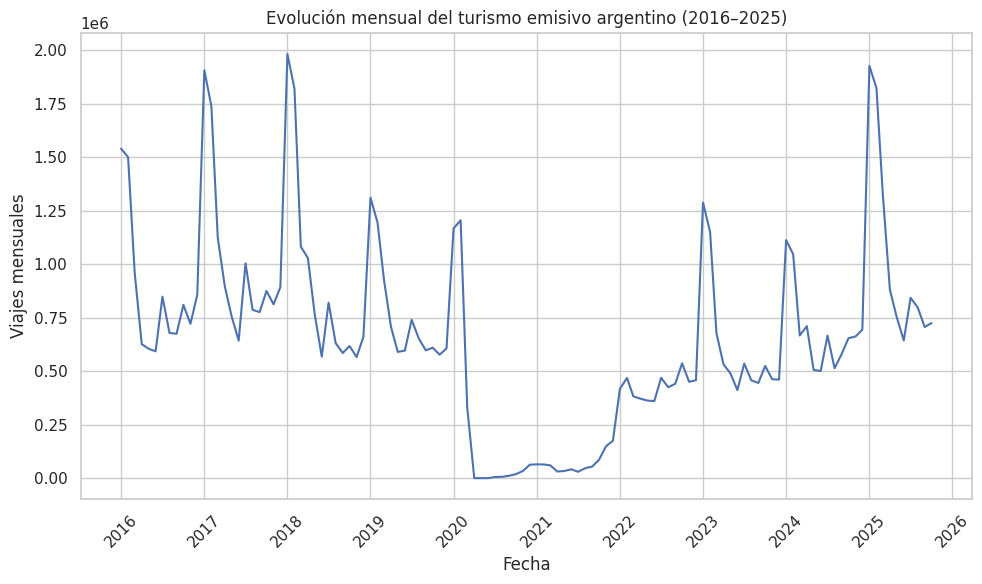

In [48]:
plt.figure()
plt.plot(ts_final["indice_tiempo"], ts_final["viajes"])
plt.title("Evolución mensual del turismo emisivo argentino (2016–2025)")
plt.xlabel("Fecha")
plt.ylabel("Viajes mensuales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Interpretación

Se observa una fuerte caída en 2020 asociada a la pandemia, seguida de una recuperación progresiva en los años posteriores.

El crecimiento posterior sugiere normalización de la movilidad internacional y recuperación de la demanda turística.


### **8.2) Estacionalidad promedio**

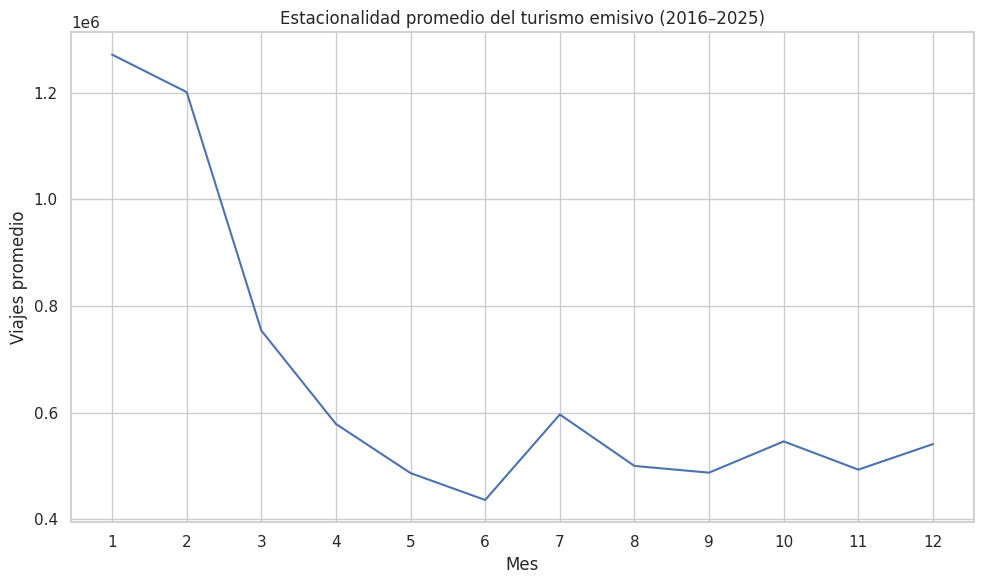

In [49]:
ts_final["mes"] = ts_final["indice_tiempo"].dt.month

estacionalidad = (
    ts_final.groupby("mes", as_index=False)
    .agg(viajes_promedio=("viajes", "mean"))
)

plt.figure()
plt.plot(estacionalidad["mes"], estacionalidad["viajes_promedio"])
plt.title("Estacionalidad promedio del turismo emisivo (2016–2025)")
plt.xlabel("Mes")
plt.ylabel("Viajes promedio")
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()


### Interpretación

Se identifican picos en los meses de verano (enero–febrero) y en períodos vacacionales, lo que evidencia un patrón estacional marcado.

Esto confirma que la demanda turística internacional presenta comportamiento cíclico anual.


### **8.3) Ranking de destinos**

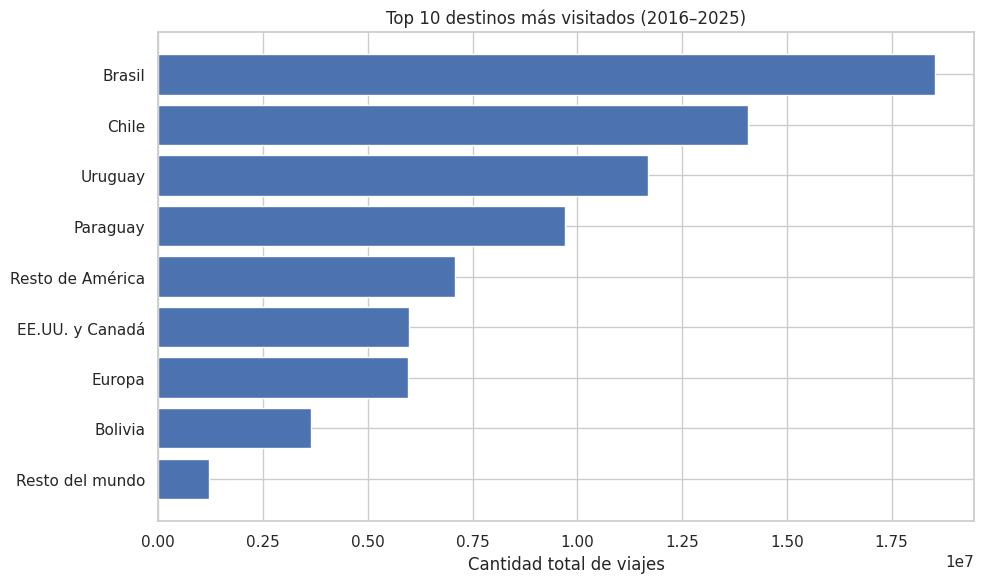

In [50]:
destinos_totales = (
    df.groupby("pais_destino", as_index=False)
      .agg(viajes_de_turistas_residentes=("viajes_de_turistas_residentes", "sum"))
      .sort_values("viajes_de_turistas_residentes", ascending=False)
)

top10 = destinos_totales.head(10)

plt.figure()
plt.barh(top10["pais_destino"], top10["viajes_de_turistas_residentes"])
plt.gca().invert_yaxis()
plt.title("Top 10 destinos más visitados (2016–2025)")
plt.xlabel("Cantidad total de viajes")
plt.tight_layout()
plt.show()


### Interpretación (Destinos)

Los destinos más elegidos se concentran en países/regiones cercanas, lo que sugiere que la proximidad geográfica, la conectividad y los costos relativos influyen fuertemente en la elección.

La concentración en pocos destinos indica una estructura de demanda focalizada, con predominio de viajes regionales sobre destinos de larga distancia.


### **8.4) Destinos más visitados (solo transporte aéreo)**

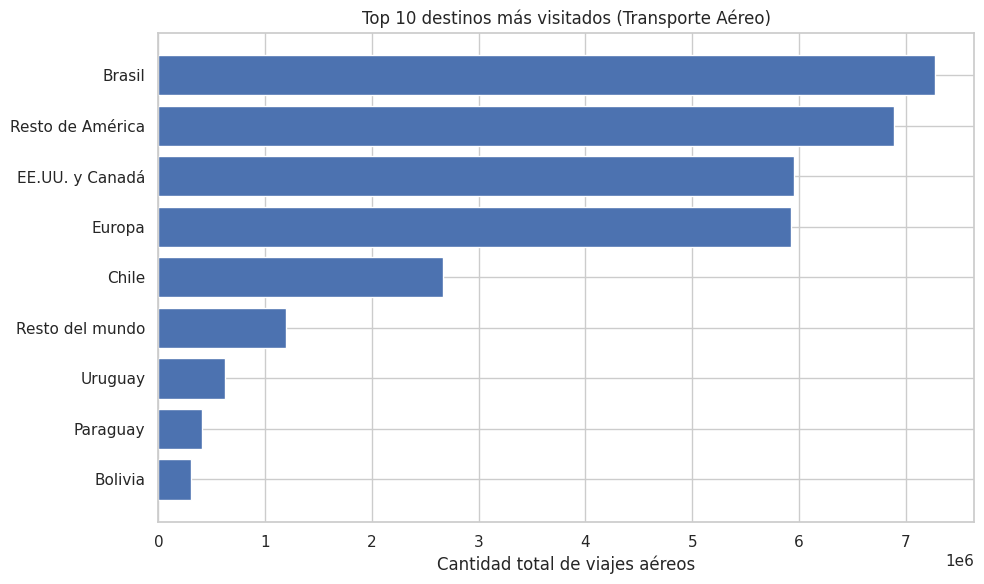

In [51]:
df_aereo = df[df["medio_de_transporte"].str.lower() == "aérea"]

destinos_aereo = (
    df_aereo.groupby("pais_destino", as_index=False)
      .agg(viajes_aereos=("viajes_de_turistas_residentes", "sum"))
      .sort_values("viajes_aereos", ascending=False)
)

top10_aereo = destinos_aereo.head(10)

plt.figure()
plt.barh(top10_aereo["pais_destino"], top10_aereo["viajes_aereos"])
plt.gca().invert_yaxis()
plt.title("Top 10 destinos más visitados (Transporte Aéreo)")
plt.xlabel("Cantidad total de viajes aéreos")
plt.tight_layout()
plt.show()


### Interpretación

Al filtrar únicamente por transporte aéreo, se observa una mayor presencia de destinos de larga distancia en el ranking.

Esto indica que el transporte aéreo es determinante para viajes internacionales fuera de la región y refleja un perfil de viaje diferente respecto al transporte terrestre.

El análisis segmentado permite comprender mejor la estructura real de la demanda turística.



 ### **8.5) Participación del transporte aéreo por destino**


In [52]:
# Total de viajes por destino (todos los medios)
total_destino = (
    df.groupby("pais_destino", as_index=False)
      .agg(total_viajes=("viajes_de_turistas_residentes", "sum"))
)

# Total de viajes aéreos por destino
aereo_destino = (
    df[df["medio_de_transporte"].str.lower() == "aérea"]
    .groupby("pais_destino", as_index=False)
    .agg(viajes_aereos=("viajes_de_turistas_residentes", "sum"))
)

# Merge
participacion = total_destino.merge(aereo_destino, on="pais_destino", how="left")
participacion["viajes_aereos"] = participacion["viajes_aereos"].fillna(0)

# Calcular porcentaje
participacion["pct_aereo"] = (
    participacion["viajes_aereos"] / participacion["total_viajes"]
) * 100

# Ordenar de mayor a menor participación aérea
participacion = participacion.sort_values("pct_aereo", ascending=False)

participacion.head(10)


,pais_destino,total_viajes,viajes_aereos,pct_aereo
3,EE.UU. y Canadá,5987686,5951777,99.400286
4,Europa,5965749,5927272,99.355035
7,Resto del mundo,1204836,1193105,99.026341
6,Resto de América,7075310,6884667,97.305517
1,Brasil,18541809,7274121,39.230913
2,Chile,14065967,2664411,18.942253
0,Bolivia,3634345,308104,8.477566
8,Uruguay,11684978,623580,5.336595
5,Paraguay,9706538,404494,4.167232


 ### **8.6) Participación porcentual del transporte aéreo por destino**

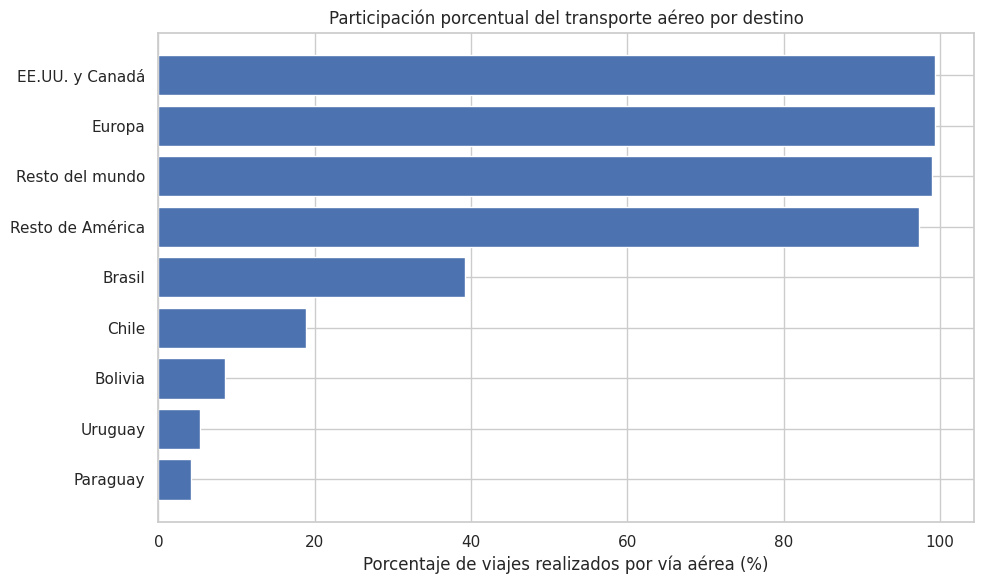

In [53]:
top_participacion = participacion.sort_values("pct_aereo", ascending=False).head(10)

plt.figure()
plt.barh(top_participacion["pais_destino"], top_participacion["pct_aereo"])
plt.gca().invert_yaxis()
plt.title("Participación porcentual del transporte aéreo por destino")
plt.xlabel("Porcentaje de viajes realizados por vía aérea (%)")
plt.tight_layout()
plt.show()


### Interpretación

La participación porcentual del transporte aéreo permite identificar la dependencia modal de cada destino.

Los destinos de larga distancia presentan una participación aérea cercana al 100%, mientras que los destinos regionales muestran una mayor proporción de viajes terrestres.

Este análisis de composición revela diferencias estructurales en la demanda turística y aporta mayor profundidad al estudio de los patrones de movilidad internacional.


### **8.7) Concentración de destinos en viajes aéreos (Top + Otros)**

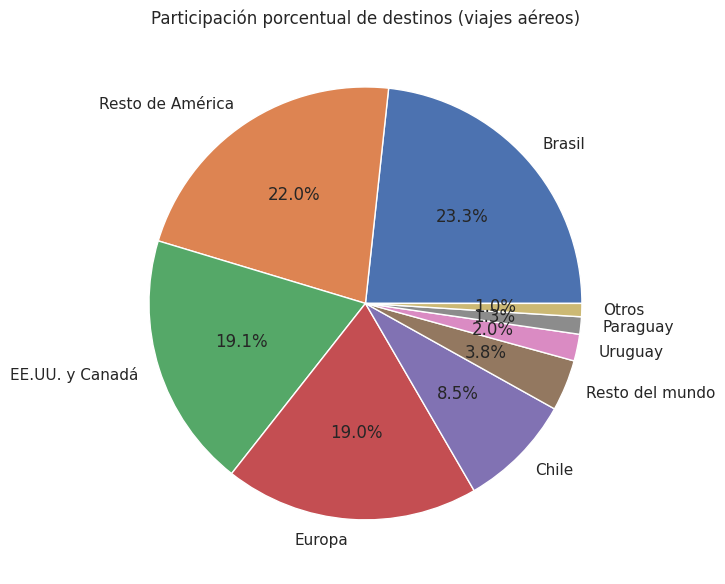

In [54]:
# Filtrar solo transporte aéreo
df_aereo = df[df["medio_de_transporte"].str.lower() == "aérea"]

# Total viajes aéreos por destino
aereo_destinos = (
    df_aereo.groupby("pais_destino", as_index=False)
    .agg(viajes_aereos=("viajes_de_turistas_residentes", "sum"))
    .sort_values("viajes_aereos", ascending=False)
)

# Tomar top 8 destinos
top_n = 8
top_aereo = aereo_destinos.head(top_n).copy()

# Calcular "Otros"
otros = pd.DataFrame({
    "pais_destino": ["Otros"],
    "viajes_aereos": [aereo_destinos["viajes_aereos"].iloc[top_n:].sum()]
})

# Unir
pie_data = pd.concat([top_aereo, otros], ignore_index=True)

# Calcular porcentaje
pie_data["porcentaje"] = (
    pie_data["viajes_aereos"] / pie_data["viajes_aereos"].sum()
) * 100

# Gráfico de torta
plt.figure()
plt.pie(
    pie_data["porcentaje"],
    labels=pie_data["pais_destino"],
    autopct="%1.1f%%"
)
plt.title("Participación porcentual de destinos (viajes aéreos)")
plt.tight_layout()
plt.show()


### Interpretación

El gráfico muestra la concentración de la demanda aérea internacional por destino.

Se observa que una proporción significativa de los viajes aéreos se concentra en un conjunto reducido de países, mientras que el resto se distribuye entre múltiples destinos con menor participación individual.

Esto evidencia una estructura de mercado concentrada en determinados polos turísticos internacionales.


### **8.8) Distribución por medio de transporte**

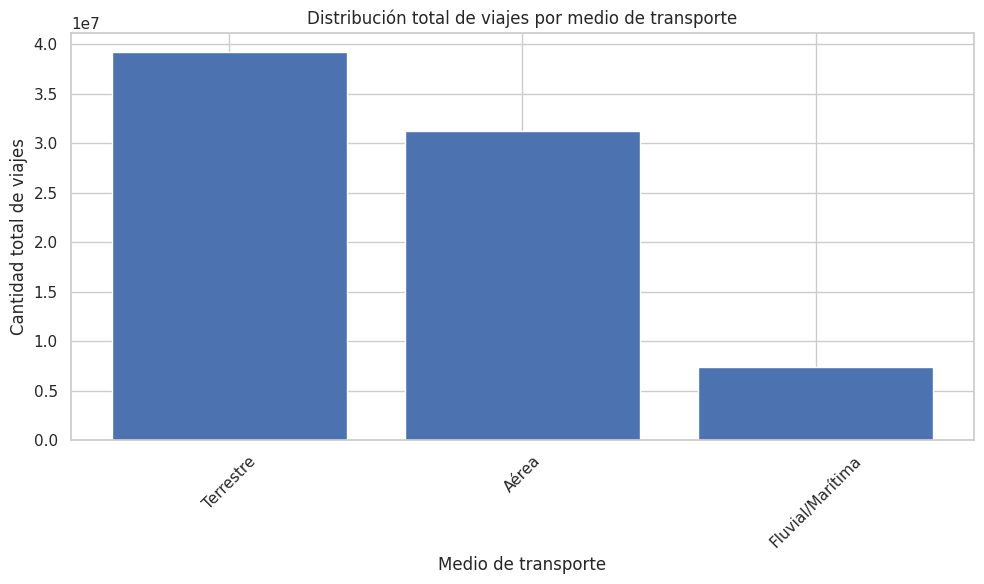

In [55]:
medios_totales = (
    df.groupby("medio_de_transporte", as_index=False)
      .agg(viajes_totales=("viajes_de_turistas_residentes", "sum"))
      .sort_values("viajes_totales", ascending=False)
)

plt.figure()
plt.bar(medios_totales["medio_de_transporte"], medios_totales["viajes_totales"])
plt.title("Distribución total de viajes por medio de transporte")
plt.xlabel("Medio de transporte")
plt.ylabel("Cantidad total de viajes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Interpretación

El gráfico muestra la distribución total acumulada de viajes al exterior según medio de transporte durante el período analizado (2016–2025).

Se observa que el transporte aéreo y el transporte terrestre concentran la mayor proporción de los viajes internacionales.

El predominio del transporte terrestre se explica principalmente por la alta frecuencia de viajes hacia países limítrofes, donde la cercanía geográfica permite el desplazamiento por vía terrestre.

Por su parte, el transporte aéreo resulta fundamental para destinos de mayor distancia y mercados internacionales fuera de la región.

Esta distribución evidencia que la estructura del turismo emisivo argentino combina un fuerte componente regional (viajes terrestres) con un segmento internacional de mayor distancia dependiente del transporte aéreo.

En términos estratégicos, el mercado turístico internacional argentino presenta una dualidad modal: regional-terrestre y extra-regional-aéreo.


## **9) Relaciones macroeconómicas y sensibilidad cambiaria**

### **9.1) Heatmap de correlaciones**

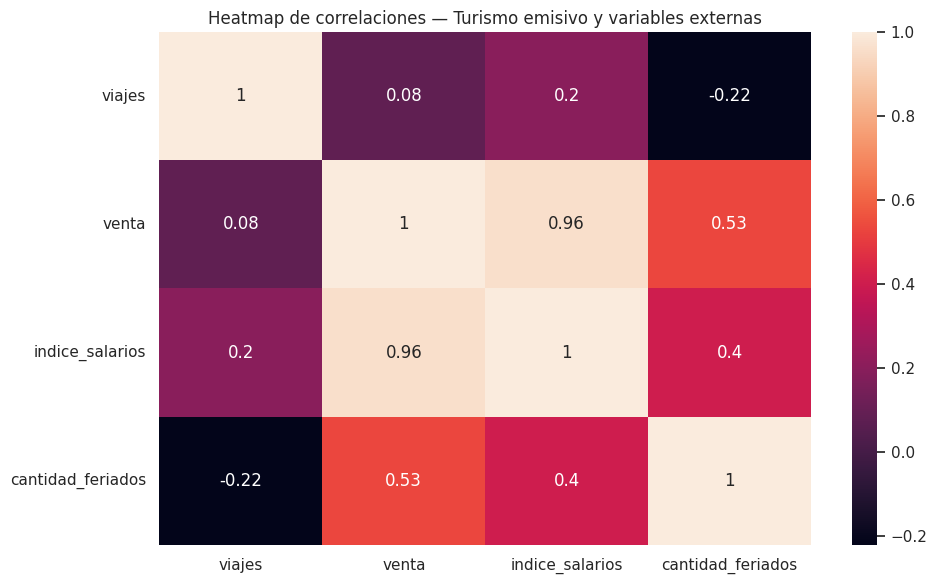

In [56]:

corr = ts_final[["viajes","venta","indice_salarios","cantidad_feriados"]].corr()

plt.figure()
sns.heatmap(corr, annot=True)
plt.title("Heatmap de correlaciones — Turismo emisivo y variables externas")
plt.tight_layout()
plt.show()


## Interpretación del Heatmap de Correlaciones

El heatmap muestra **correlaciones lineales (coeficiente de Pearson)** entre las principales variables del análisis.

La correlación mide la fuerza y dirección de la relación lineal entre dos variables.  
Sus valores van de **-1 a 1**:

- **Cerca de 1** → relación positiva fuerte (ambas variables se mueven en la misma dirección).
- **Cerca de -1** → relación negativa fuerte (cuando una sube, la otra baja).
- **Cerca de 0** → relación débil o inexistente.

---

### Resultados observados

| Relación                              | Correlación | Interpretación |
|---------------------------------------|-------------|---------------|
| Viajes – Tipo de cambio (venta)      | 0.08        | Relación muy débil y prácticamente nula en niveles. No se observa una asociación lineal fuerte entre el nivel del dólar y la cantidad de viajes. |
| Viajes – Índice de salarios          | 0.20        | Relación positiva débil. Sugiere que mayores salarios podrían asociarse con más viajes, aunque el efecto no es fuerte. |
| Viajes – Cantidad de feriados        | -0.22       | Relación negativa moderada-débil. Resultado contraintuitivo respecto a la hipótesis inicial; podría indicar que los feriados no necesariamente impulsan viajes al exterior. |
| Tipo de cambio – Índice de salarios  | 0.96        | Correlación muy alta. Ambas variables crecen fuertemente en el tiempo, lo que sugiere posible multicolinealidad en el modelo. |
| Tipo de cambio – Feriados            | 0.53        | Relación positiva moderada, posiblemente asociada a patrones temporales compartidos. |
| Salarios – Feriados                  | 0.40        | Relación positiva moderada, probablemente vinculada a estacionalidad económica. |

---

### Conclusión

El análisis en niveles muestra relaciones débiles entre viajes y variables macroeconómicas.  
La alta correlación entre tipo de cambio e índice de salarios sugiere que el modelo en variaciones porcentuales es metodológicamente más apropiado para analizar dinámicas económicas y evitar problemas de multicolinealidad.


### **9.2) Sensibilidad al tipo de cambio por destino**

In [57]:
ranking = []

for pais in df["pais_destino"].unique():
    temp = (
        df[df["pais_destino"] == pais]
        .groupby("indice_tiempo", as_index=False)
        .agg(viajes=("viajes_de_turistas_residentes","sum"))
        .merge(df_dolar_mensual[["indice_tiempo","venta"]],
               on="indice_tiempo", how="left")
    )

    if len(temp) >= 24:
        corr = temp[["viajes","venta"]].corr().iloc[0,1]
        ranking.append((pais, corr))

df_resiliencia = (
    pd.DataFrame(ranking, columns=["pais_destino","corr_viajes_dolar"])
    .sort_values("corr_viajes_dolar")
)

df_resiliencia




,pais_destino,corr_viajes_dolar
8,Resto del mundo,-0.194976
5,EE.UU. y Canadá,-0.039361
4,Uruguay,-0.022398
0,Bolivia,-0.011900
3,Paraguay,0.032855
2,Chile,0.079514
1,Brasil,0.111964
6,Resto de América,0.186013
7,Europa,0.284536


### Análisis de resiliencia

La correlación negativa más fuerte indica mayor sensibilidad al tipo de cambio.
Los destinos con correlaciones más cercanas a cero muestran mayor resiliencia ante variaciones cambiarias.

Esto sugiere que no todos los destinos reaccionan de igual manera frente a shocks macroeconómicos.


## Ranking de Sensibilidad / Resiliencia al Tipo de Cambio

La siguiente tabla muestra la correlación entre la cantidad de viajes a cada destino y el tipo de cambio.  
Una correlación más negativa indica mayor sensibilidad ante aumentos del dólar.  
Una correlación más cercana a cero indica mayor resiliencia.

| País / Región        | Correlación viajes–dólar | Interpretación |
|----------------------|--------------------------|---------------|
| Resto del mundo      | -0.195                   | Mayor sensibilidad. Cuando el dólar aumenta, los viajes tienden a disminuir con mayor intensidad. |
| EE.UU. y Canadá      | -0.039                   | Sensibilidad leve. Relación negativa muy débil. |
| Uruguay              | -0.022                   | Prácticamente neutro. Muestra alta resiliencia frente a variaciones cambiarias. |
| Bolivia              | -0.012                   | Relación casi nula. Alta estabilidad ante movimientos del tipo de cambio. |
| Paraguay             | 0.033                    | Relación positiva muy débil. No muestra evidencia de sensibilidad clara. |
| Chile                | 0.080                    | Relación positiva débil. Puede estar influenciada por factores adicionales. |
| Brasil               | 0.112                    | Relación positiva moderada-débil. Indica baja sensibilidad directa al dólar. |
| Resto de América     | 0.186                    | Relación positiva moderada. Podría reflejar otros determinantes de la demanda. |
| Europa               | 0.285                    | Relación positiva más marcada. Sugiere dinámica diferente respecto a destinos regionales. |

---

### Conclusión

Los destinos regionales (Uruguay, Bolivia, Paraguay) presentan mayor estabilidad ante variaciones del tipo de cambio.  
En cambio, destinos más lejanos muestran patrones distintos, posiblemente influenciados por factores estructurales como planificación anticipada, perfil socioeconómico del viajero o tipo de viaje.

Esto evidencia que la sensibilidad cambiaria no es homogénea entre destinos.


Europa presenta una correlación positiva moderada (0.285) entre viajes y tipo de cambio.
Esto no implica necesariamente que el aumento del dólar incentive los viajes, sino que ambas variables muestran una tendencia creciente en el tiempo, especialmente en el período post-pandemia.

Además, los viajes a Europa pueden estar asociados a un perfil de viajero con mayor capacidad adquisitiva y planificación anticipada, lo que podría reducir su sensibilidad a variaciones cambiarias de corto plazo.


> Nota: estas correlaciones describen asociación lineal y **no implican causalidad**. Pueden estar influenciadas por tendencias temporales, shocks (pandemia) u otros factores no observados.


### **9.3) Scatter dólar % vs viajes**

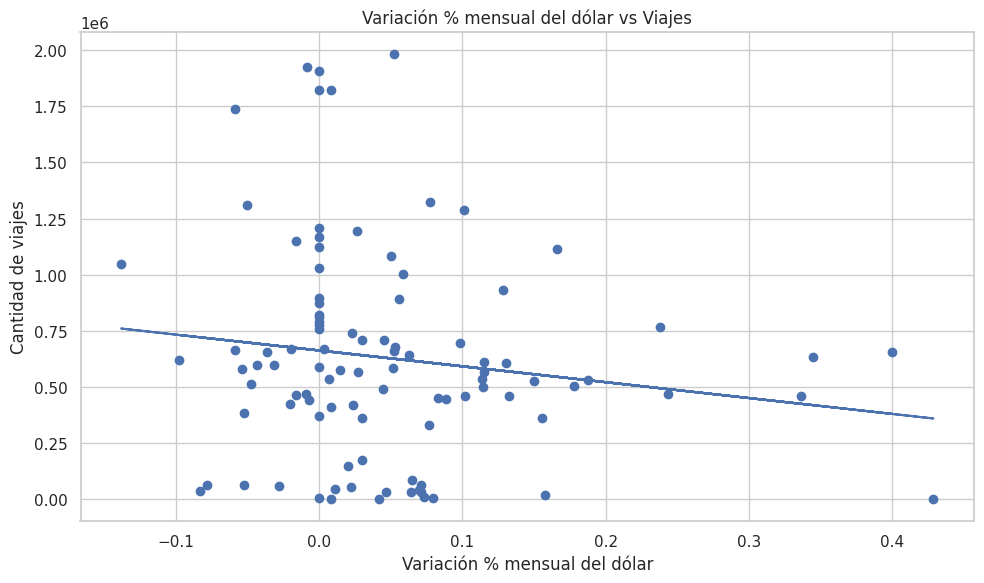

In [58]:
model_data = ts_final.dropna(subset=["viajes", "venta", "indice_salarios"]).copy()

model_data["dolar_pct"] = model_data["venta"].pct_change()
model_data["salario_pct"] = model_data["indice_salarios"].pct_change()
model_data = model_data.dropna(subset=["dolar_pct", "salario_pct"])

x = model_data["dolar_pct"].values
y = model_data["viajes"].values

m, b = np.polyfit(x, y, 1)

plt.figure()
plt.scatter(x, y)
plt.plot(x, m*x + b)
plt.title("Variación % mensual del dólar vs Viajes")
plt.xlabel("Variación % mensual del dólar")
plt.ylabel("Cantidad de viajes")
plt.tight_layout()
plt.show()


### **9.4) Scatter salario % vs viajes**

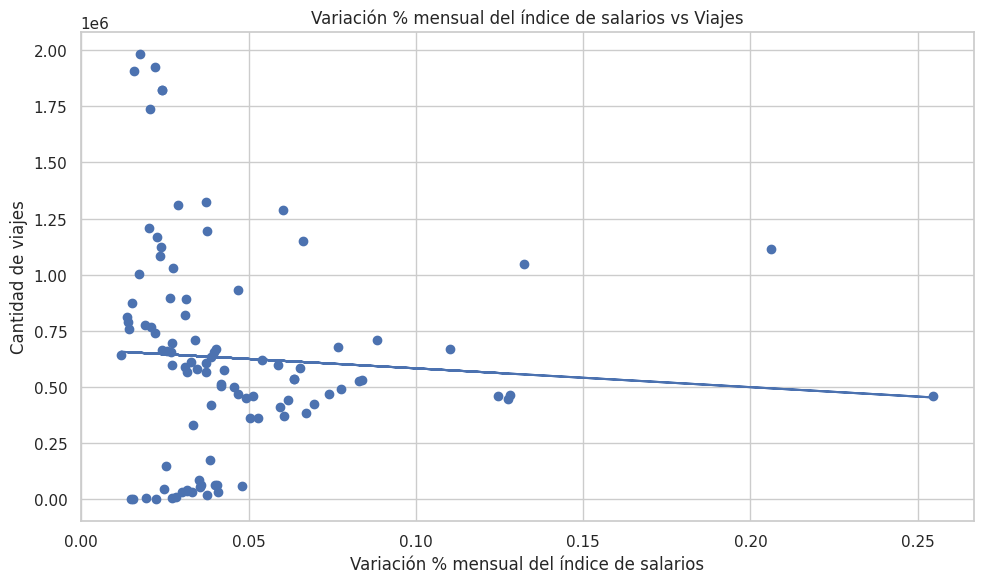

In [59]:
x = model_data["salario_pct"].values
y = model_data["viajes"].values

m, b = np.polyfit(x, y, 1)

plt.figure()
plt.scatter(x, y)
plt.plot(x, m*x + b)
plt.title("Variación % mensual del índice de salarios vs Viajes")
plt.xlabel("Variación % mensual del índice de salarios")
plt.ylabel("Cantidad de viajes")
plt.tight_layout()
plt.show()


### Interpretación

Los gráficos muestran alta dispersión y ausencia de una relación lineal fuerte en el corto plazo.

Esto es consistente con los resultados preliminares del modelo, donde las variaciones mensuales del tipo de cambio y del índice de salarios no explican de manera contundente las fluctuaciones en la cantidad de viajes.

La dinámica del turismo emisivo parece estar influenciada por múltiples factores estructurales y no únicamente por shocks macroeconómicos mensuales.


## **10) Modelo econométrico**
En esta sección se estima un modelo lineal para evaluar la relación entre el turismo emisivo y variables externas (tipo de cambio, salarios y feriados).



### **10.1 Especificación del modelo**

Para evitar problemas de tendencia y relaciones espurias en niveles, se utilizan **variaciones porcentuales mensuales**:

- `dolar_pct`: variación % mensual del tipo de cambio
- `salario_pct`: variación % mensual del índice de salarios

Se incorpora además:
- `cantidad_feriados`: número de feriados del mes (proxy de impulsos de calendario)

**Variable dependiente:** `viajes` (cantidad mensual de viajes al exterior).


### **10.2) Estimación del modelo (período con datos completos)**

In [60]:
import statsmodels.api as sm

# Usar solo meses con datos completos (evita NaN en salarios)
model_data = ts_final.dropna(subset=["viajes", "venta", "indice_salarios"]).copy()

# Variaciones % mensuales
model_data["dolar_pct"] = model_data["venta"].pct_change()
model_data["salario_pct"] = model_data["indice_salarios"].pct_change()

# Eliminar NaN por pct_change
model_data = model_data.dropna(subset=["dolar_pct", "salario_pct"])

print("✅ Rango real usado en el modelo:")
print(model_data["indice_tiempo"].min(), "a", model_data["indice_tiempo"].max())
print("Filas usadas:", model_data.shape[0])

X = model_data[["dolar_pct", "salario_pct", "cantidad_feriados"]]
y = model_data["viajes"]

X = sm.add_constant(X)
modelo = sm.OLS(y, X).fit()

print(modelo.summary())


✅ Rango real usado en el modelo:
2017-01-01 00:00:00 a 2025-03-01 00:00:00
Filas usadas: 99
                            OLS Regression Results                            
Dep. Variable:                 viajes   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     2.427
Date:                Mon, 16 Feb 2026   Prob (F-statistic):             0.0702
Time:                        19:43:15   Log-Likelihood:                -1429.0
No. Observations:                  99   AIC:                             2866.
Df Residuals:                      95   BIC:                             2876.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

###**10.3) Interpretación de resultados (en base a hipótesis)**

- **Hipótesis 3 (Tipo de cambio):** el coeficiente de `dolar_pct` presenta signo negativo (consistente con la intuición económica), pero su significancia estadística es limitada. Esto sugiere que el efecto mensual del dólar sobre los viajes no es concluyente en el corto plazo.

- **Hipótesis 4 (Salarios):** el coeficiente de `salario_pct` tiene signo positivo, pero no resulta estadísticamente significativo. Por lo tanto, no se encuentra evidencia sólida de que variaciones mensuales del índice de salarios expliquen cambios en los viajes al exterior.

- **Hipótesis 5 (Feriados):** `cantidad_feriados` resulta estadísticamente significativa en el modelo estimado. Sin embargo, el signo negativo indica una relación distinta a la esperada inicialmente, lo que puede sugerir que los feriados impulsan en mayor medida turismo interno o que operan otros efectos de calendario.

En conjunto, el modelo tiene **poder explicativo bajo**, lo que indica que el turismo emisivo depende de múltiples factores adicionales no incluidos en esta especificación.


### **10.4) Limitaciones del análisis**

- El R² del modelo es bajo, por lo que una parte importante de la variación en los viajes no se explica con las variables incluidas.
- Existe alta correlación entre tipo de cambio y salarios, lo que puede generar **multicolinealidad** y afectar la estabilidad de los coeficientes.
- El estadístico Durbin–Watson sugiere posible **autocorrelación** en residuos, frecuente en series temporales.
- El análisis trabaja con datos agregados mensuales, lo que puede ocultar diferencias por segmento, perfil de viajero o motivo del viaje.

Por estas razones, el modelo debe interpretarse como una aproximación exploratoria (no como un modelo predictivo definitivo).


### **11) Insights principales**

A partir del análisis exploratorio y del modelo econométrico, se identifican los siguientes hallazgos clave:

1. **Estacionalidad marcada:**  
   El turismo emisivo argentino presenta picos claros en los meses de verano, confirmando un patrón estacional fuerte.

2. **Alta concentración regional:**  
   Los destinos más visitados se concentran en países limítrofes, lo que evidencia la importancia de la proximidad geográfica y los costos relativos.

3. **Estructura modal dual:**  
   El turismo emisivo combina un componente regional-terrestre y un componente internacional-aéreo, con destinos de larga distancia dependientes casi exclusivamente del transporte aéreo.

4. **Sensibilidad cambiaria heterogénea:**  
   No todos los destinos reaccionan de la misma manera ante variaciones del tipo de cambio. Algunos muestran mayor resiliencia estructural.

5. **Impacto macroeconómico limitado en el corto plazo:**  
   Las variaciones mensuales del tipo de cambio y salarios no explican de manera contundente las fluctuaciones mensuales de viajes.

6. **Feriados como variable relevante:**  
   La variable feriados resulta significativa en el modelo, aunque su signo sugiere dinámicas más complejas que requieren análisis adicional.


## **12. Conclusión General**

El turismo emisivo argentino presenta un comportamiento estructuralmente estacional y regionalmente concentrado.

Si bien variables macroeconómicas como el tipo de cambio y el índice de salarios influyen en la dinámica general del sector, su impacto mensual no resulta determinante de manera aislada.

El análisis sugiere que el turismo internacional depende de múltiples factores estructurales, incluyendo:

- Conectividad aérea
- Proximidad geográfica
- Perfil socioeconómico del viajero
- Factores institucionales y regulatorios

En consecuencia, el turismo emisivo debe entenderse como un fenómeno multidimensional que combina elementos económicos, geográficos y sociales.


## **13. Respuesta a las hipótesis planteadas**

- **Hipótesis 1:** Confirmada. Existe estacionalidad marcada.
- **Hipótesis 2:** Confirmada. Los destinos regionales concentran mayor volumen.
- **Hipótesis 3:** Parcialmente respaldada. El signo es consistente, pero la evidencia estadística es limitada.
- **Hipótesis 4:** No confirmada de forma concluyente en el corto plazo.
- **Hipótesis 5:** Parcialmente confirmada. Los feriados influyen, aunque con dinámica compleja.
- **Hipótesis 6:** Confirmada. La sensibilidad cambiaria varía según destino.
